In [1]:
import sqlite3
import pandas as pd
import nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt
from scikitplot.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_predict

from textblob import Word
from textblob import TextBlob
from sklearn.metrics import classification_report

import utils.data_prep as data_prep

stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

### Prepare Dataset

In [2]:
data_set = data_prep.get_dataset()
data_set["length"] = data_set["paragraph"].apply(lambda x: len(nltk.word_tokenize(x)))
data_set["length_comp"] = data_set["paragraph"].apply(len)

In [25]:
cnt_table = data_set.groupby(['class','section'])['class'].count().rename('cnt')
cnt_table

class  section                            
0      assets_held_for_sale                     200
1      associates, subsidiaries and others     4352
2      auditors fee                            2306
3      auditors report                         2361
4      borrowings and other liabilities        2098
5      business combinations                   3757
6      cash flow notes                         2388
7      cash_equiv                              2459
8      deferred taxes                          2286
9      discopsic                                596
10     employees                               1428
11     eps                                     2893
12     equity                                  7087
13     events after the reporting period       2020
14     financial assets                        1668
15     financial instruments                  26052
16     financial_liabilities                   6054
17     general                                37823
18     goodwill      

In [6]:
#class_filter = ((cnt_table<8000) & (cnt_table>3000)).rename('under_10000')

#data_set2 = data_set.merge(class_filter.reset_index(),on="class",how='inner')
#data_set2.shape

(246399, 11)

In [63]:
#(data_set2["length"]>5)&(data_set2['under_10000']==True)
data_set2 = data_set
df = data_set2.loc[data_set2["length"]>20,:]
print(df.shape)
df.head()

(29794, 9)


,company,year,page,paragraph_nr,paragraph,section,class,length,length_comp
3,BASF,2016,4,67,We have audited the consolidated financial sta...,auditors report,3,277,1688
4,BASF,2016,4,68,assurance. Knowledge of the business activitie...,auditors report,3,270,1657
61,BASF,2016,6,125,Gains/losses that cannot be reclassified \naf...,prim_ic,38,25,112
75,BASF,2016,6,139,1 For more information on other comprehensive ...,prim_ic,38,61,303
97,BASF,2016,6,161,1 Reclassification to retained earnings in acc...,prim_ic,38,21,116


In [ ]:
X = df['paragraph']
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
#('vect', StemmedCountVectorizer(stop_words='english')),
text_clf_svm = Pipeline([   ('vect', CountVectorizer()),
                            ('tfidf', TfidfTransformer()),
                        #     ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',tol=1e-3,max_iter=3000))
                             ('clf-svm', SVC(kernel='linear'))
                        ])
text_clf_fit = text_clf_svm.fit(X_train, y_train)

text_clf_fit.score(X_test,y_test)

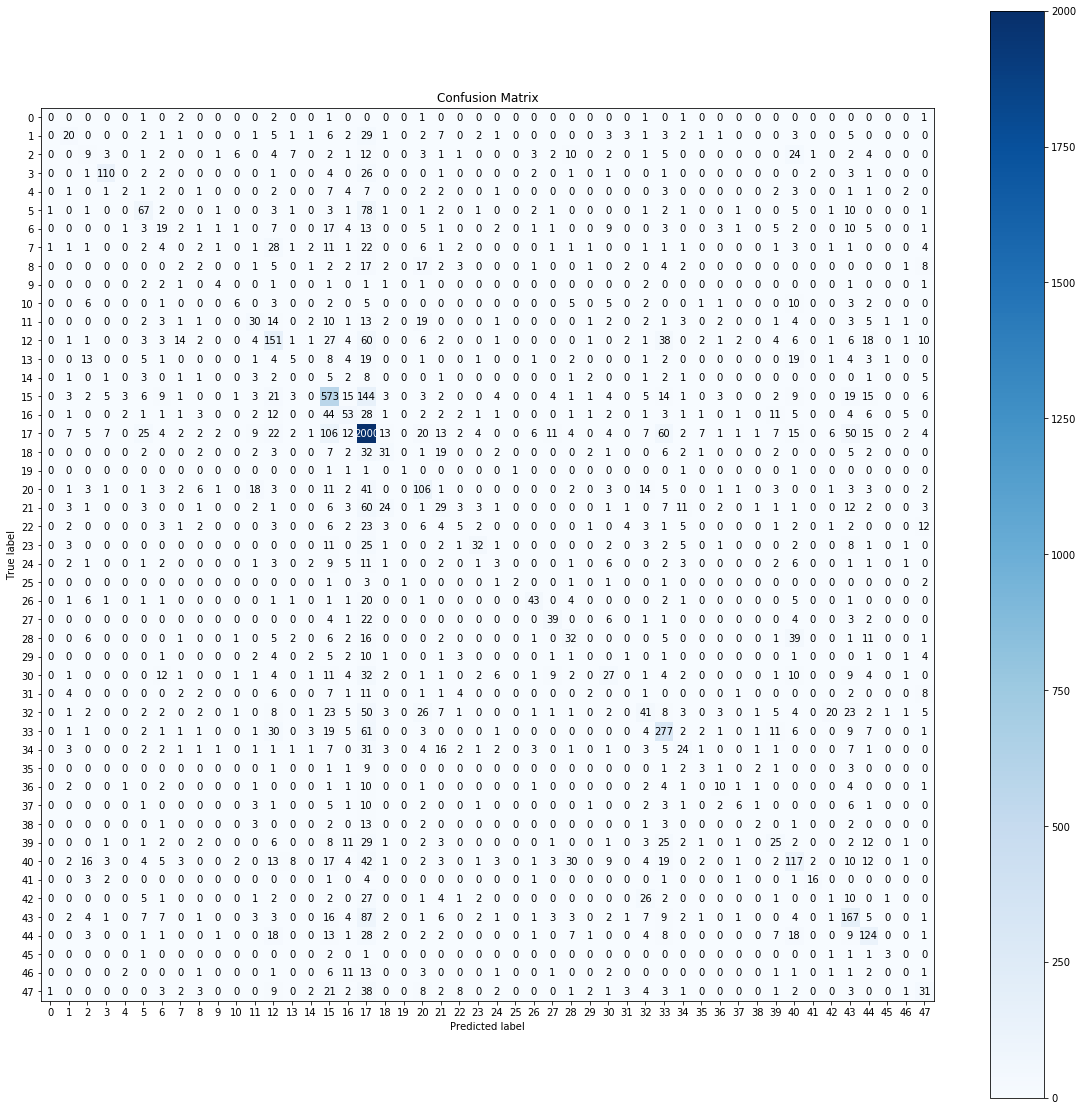

In [65]:
y_pred = cross_val_predict(text_clf_fit, X_test, y_test)
plt.figure(figsize=(20,20))
plot_confusion_matrix(y_test, y_pred,figsize=(20,20))
plt.show();

In [66]:
print(classification_report(y_true=y_test,y_pred=y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        10
          1       0.32      0.19      0.24       104
          2       0.11      0.08      0.09       107
          3       0.81      0.70      0.75       158
          4       0.18      0.04      0.07        45
          5       0.42      0.36      0.39       188
          6       0.18      0.16      0.17       118
          7       0.00      0.00      0.00       103
          8       0.05      0.03      0.04        75
          9       0.31      0.22      0.26        18
         10       0.32      0.12      0.17        52
         11       0.32      0.24      0.27       125
         12       0.37      0.40      0.38       374
         13       0.15      0.05      0.08        96
         14       0.00      0.00      0.00        41
         15       0.54      0.65      0.59       885
         16       0.30      0.27      0.28       199
         17       0.62      0.81      0.70   

In [21]:
combined = data_set.groupby(['company','year','page','class','section'])['paragraph'].apply(lambda x: ' '.join(x))
combined_df = combined.reset_index()

#combined_df = combined_df.loc[combined_df['class']!=17,:]

combined_df.head()

classes = (combined_df.groupby(['class','section'])['page'].count()>0).rename('signifcant').reset_index()
relevant_classes = classes.loc[classes['signifcant'],:] #
#relevant_classes = classes

combined_df = combined_df.merge(relevant_classes,on='class',how='inner')

#combined_df.loc[combined_df['signifcant'],'class'] = 48

combined_df = combined_df.groupby(['company','year','class','section_x'])['paragraph'].apply(lambda x: ' '.join(x)).reset_index()
combined_df.head()
#relevant_classes
#mask

,company,year,class,section_x,paragraph
0,Adva,2016,2,auditors fee,Supervisory \nBoard Management \nBoard Welcome...
1,Adva,2016,3,auditors report,Supervisory \nBoard Management \nBoard Welcome...
2,Adva,2016,5,business combinations,The final purchase price allocation according ...
3,Adva,2016,6,cash flow notes,130 ADVA Optical Networking – Annua...
4,Adva,2016,7,cash_equiv,108 ADVA Optical Networking – Annua...


In [25]:


X = combined_df['paragraph']
y = combined_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify = y)
#('vect', StemmedCountVectorizer(stop_words='english')),
#text_clf_svm = Pipeline([   ('vect', HashingVectorizer(stop_words='english')),
#                             ('clf-svm', BernoulliNB())])


#4
#stop_words='english'
text_clf_svm = Pipeline([   ('vect', CountVectorizer(stop_words='english',strip_accents='ascii',)),
                            ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='log', penalty='l1',tol=1e-3,max_iter=1000,class_weight='balanced'))
                           ])
# ('clf-svm', SVC(kernel='linear',C=1,class_weight='balanced')) 

text_clf_fit = text_clf_svm.fit(X_train, y_train)

text_clf_fit.score(X_test,y_test)

0.6925

/home/peter/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


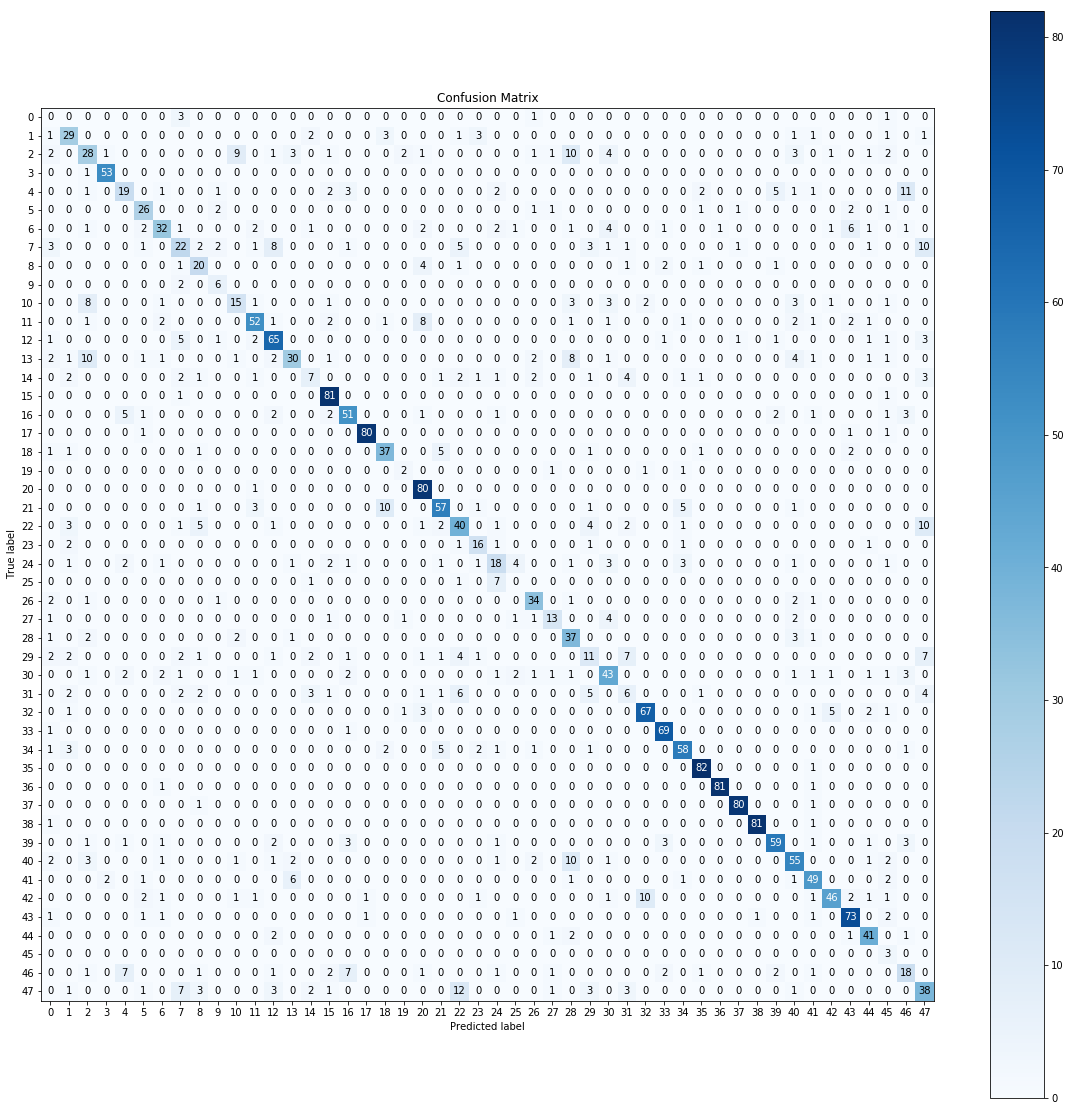

In [23]:
y_pred = cross_val_predict(text_clf_svm, X, y,cv=5)
#plt.figure(figsize=(20,20))
plot_confusion_matrix(y, y_pred,figsize=(20,20))
plt.show()

In [17]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(y_true=y,y_pred=y_pred))
#precision_recall_fscore_support

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         5
          1       0.60      0.67      0.64        43
          2       0.47      0.39      0.43        71
          3       0.95      0.98      0.96        54
          4       0.53      0.39      0.45        49
          5       0.70      0.74      0.72        35
          6       0.71      0.53      0.61        60
          7       0.44      0.35      0.39        62
          8       0.53      0.65      0.58        31
          9       0.46      0.75      0.57         8
         10       0.50      0.38      0.43        39
         11       0.80      0.68      0.74        76
         12       0.72      0.79      0.76        82
         13       0.70      0.45      0.55        67
         14       0.39      0.23      0.29        30
         15       0.84      0.98      0.90        83
         16       0.73      0.73      0.73        70
         17       0.98      0.96      0.97   

In [28]:
i=80
print(text_clf_fit.predict_proba([X_test[i]])[0].argmax())
print(text_clf_fit.predict_proba([X_test[i]])[0][y_test[i]])
print(y_test[i])
text_clf_fit.predict_proba([X_test[i]])[0]

1
0.0187757349445
24


array([  1.48355219e-03,   5.18363270e-01,   1.57386847e-02,
         2.30640455e-03,   5.47390980e-03,   7.02470773e-02,
         6.48881501e-03,   8.15904703e-03,   4.36927567e-03,
         2.98898856e-03,   5.96539676e-03,   8.32839274e-03,
         1.29531941e-02,   1.78770777e-02,   1.02438587e-02,
         2.86983341e-03,   2.10003886e-02,   4.03789113e-03,
         1.05543119e-02,   7.57352332e-03,   2.50842109e-03,
         1.00635611e-02,   7.64850195e-03,   1.38370414e-02,
         1.87757349e-02,   2.29108461e-02,   3.74097934e-03,
         6.02878882e-03,   3.44218825e-03,   8.44713028e-03,
         1.72419872e-02,   1.47771193e-02,   5.83801066e-03,
         2.81194642e-03,   8.28694326e-03,   1.05440237e-03,
         1.32049502e-03,   1.33298838e-02,   2.12025101e-03,
         7.73984963e-03,   1.89811454e-02,   4.13556054e-03,
         6.48022895e-03,   1.65319179e-02,   3.07524972e-02,
         1.20601622e-04,   6.55749250e-03,   7.49358054e-03])

In [29]:
y_test[80]

24

In [35]:
text_clf_fit.predict_proba(['21  \nLeased products Minimum lease payments of non-cancellable oper- ating leases amounting to €\u200a17,850 million (2015: \n€\u200a16,527 million) fall due as follows: in € million 31. 12. 2016 31. 12. 2015 within one year 8,692 8,079 between one and five years 9,154 8,445 later than five years 4 3 Minimum lease payments 17,850 16,527 Contingent rents of €\u200a46 million (2015: €\u200a54 million), \nbased principally on the distance driven, were rec- ognised in income. The agreements have, in part, extension and purchase options. Impairment losses amounting to €\u200a384 million (2015: \n€\u200a119 million) were recognised on leased products in \n2016 as a consequence of changes in residual value expectations. No income was recognised in 2016 from the reversal of impairment losses (2015: €\u200a24 million). 22  \nInvestments accounted for using the equity \nmethod '])

array([[  5.11184840e-05,   6.75894117e-02,   8.86230118e-03,
          8.98638264e-04,   2.29745877e-02,   2.80008861e-03,
          1.23558866e-02,   7.29345667e-03,   8.04106655e-03,
          1.26241923e-03,   1.18844165e-02,   3.72021806e-03,
          7.47446772e-03,   7.19702082e-03,   1.68938282e-02,
          8.31778920e-04,   3.49050277e-02,   6.04209519e-04,
          6.60849337e-03,   2.05354261e-03,   4.07890502e-03,
          1.11856637e-02,   2.10728980e-02,   1.86465873e-02,
          2.10696056e-01,   3.04414792e-01,   8.64699078e-04,
          3.01417812e-03,   4.53547753e-03,   1.45187927e-02,
          3.23967951e-02,   1.26305958e-02,   2.03198998e-02,
          2.45377835e-03,   5.98842333e-03,   2.05787660e-04,
          6.21937987e-04,   1.31049917e-02,   1.97248843e-03,
          1.14719216e-02,   1.13051873e-02,   4.48127648e-04,
          1.58396448e-02,   6.37129366e-03,   3.23177627e-03,
          2.71376009e-05,   1.87884113e-02,   2.54917739e-02]])